# Multi-pitch estimation using Non-Negative Matrix Factorization 
## By: Franklin Alvarez and Ningxiang Xie
### MIR course 2019

In this project we are doing the Multipitch detection task for polyphonic sounds, we has chosen the Non-negative Matrix Factorization algorithm as the core of our methodology. This notebook will guide you, step by step, through all the process of estimation, and verification, of a piano roll representation of a single audio file extracted from the MAPS database.

Please refer to the paper attached to this notebook for deeper explanation of the methodology and analysis of the results.

The notebook "performance_with_database" will show the performance of this methodology through several files on the MAPS database

In [1]:
import os
from essentia.standard import *
import mir_eval.multipitch as eval
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import NMF

def scomb(D, fs, N, scomb_th, min_fr, max_fr):
    t = None
    cents_step = int(1200*np.log2(max_fr/min_fr)/25)
    f0 = 0
    for step in range(cents_step):
        f = min_fr*(2**(step*25/1200))
        s = 0
        for m in range(len(D)):
            s = s + (D[m]**2)*(1 - np.cos(2*np.pi*(m*fs/N)/f))
        if t is None or s < t:
            t = s*1.0
            if t < scomb_th:
                f0 = float(f)
    return f0

def plotWH(R, Wsort, N, maxplotfreq, min_fr, fs, frmTime, Hsort, fig_dir, midi_list, tag):
    cmap = plt.get_cmap('binary')
    fbins_plot = float(fs)*np.arange(N*maxplotfreq/fs)/N # frequency bins to plot
    plt.figure(figsize=(15, 10))
    plt.subplot(211)
    plt.pcolormesh(np.arange(R+1), fbins_plot[fbins_plot > min_fr], Wsort[np.where(fbins_plot > min_fr)[0],:], cmap = cmap)
    plt.yscale('symlog')
    plt.yticks(midi_list[::12], ['A0','A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7'])
    plt.grid(True, which = 'major', axis = 'both')
    plt.ylabel('Frequencies (Hz)')
    plt.xlabel('Pitch features')
    plt.title('W matrix - Spectrum of every feature - {}'.format(tag))
    plt.subplot(212)
    plt.pcolormesh(frmTime, np.arange(R+1), Hsort, cmap = cmap)
    plt.grid(True, which = 'both', axis = 'y')
    plt.ylabel('Pitch features')
    plt.xlabel('Time (s)')
    plt.title('H matrix -  Appearance of every feature in time - {}'.format(tag))
    plt.tight_layout()
    plt.savefig(fig_dir + '/H_W_{}.png'.format(tag))
    plt.show()
    return

def MIDI_constrain(good_features, f0list, midi_list):
    for c in good_features:
        diff = list(abs(np.log10(f0list[c]/midi_list)))
        f0list[c] = midi_list[diff.index(min(diff))]
    return f0list

def pianoRoll(R, pitches, midi_list):
    piano_roll = []
    for frame in range(len(pitches)):
        roll = np.zeros(R)
        # for every voice, set a 1 into the correct pitch per frame
        for v in range(len(pitches[frame])):
            roll[midi_list.index(pitches[frame][v])] = 1.0
        piano_roll.append(roll)
    return piano_roll

def estimation(W, H, midi_list, good_features, f0list, amp_thr, R, min_dur, fs, Hop, tag):
    print('------------------------------{}----------------------------'.format(tag))
    print('Computing reference values for note on/off estimation ...')
    max_power = 0
    # list of sumed bins of every feature in W
    sum_W = [sum(col) for col in np.transpose(W)]
    for fr in np.transpose(H):
        # List to collect total power of each pitch per frame
        pitch_power = np.zeros(len(midi_list))
        for val in good_features:
            mid_index = midi_list.index(f0list[val])
            pitch_power[mid_index] += (sum_W[mid_index]*fr[val])
        # Obtain max power of a pitch in one frame
        max_fr_power = max([norm for norm in pitch_power])
        max_power = max(max_power, max_fr_power)
    print('Maximum power of a pitch detected in 1 frame {}:'.format(tag), max_power)

    # Algorithm for on/off notes detection
    print('defining onsets and offsets of pitches ...')
    pitches_prev = []    # List of pitches detected per frame
    # Detect pitches within a frame
    midi_pitch_power = []
    for fr in np.transpose(H):
        fr_pitches = [] # set of pitches per frame
        pitch_power = np.zeros(len(midi_list))
        # Sum total magnitude for a pitch within a frame
        for val in good_features:
            mid_index = midi_list.index(f0list[val])
            pitch_power[mid_index] += (sum_W[mid_index]*fr[val])
        # compare every pitch with reference power
        midi_pitch_power.append(pitch_power)
        for p in range(len(pitch_power)):
            pitch = (pitch_power[p])
            if pitch > max_power*10**(-amp_thr/20):
                fr_pitches.append(midi_list[p])
        pitches_prev.append(fr_pitches)

    # Compute an estimated piano roll of the song
    print('Computing preliminary estimated piano roll')
    piano_roll = pianoRoll(R, pitches_prev, midi_list)

    # Filter the notes that length is less than 80ms
    print('filtering pitches with duration lower than 80ms ...')
    min_frame_dur = int(np.ceil(fs*(min_dur/1000.0)/Hop)) # 80ms in frames
    # Transpose the piano roll to loop over every midi note
    t_roll = np.transpose(piano_roll)
    for m in range(len(t_roll)):
        m_note = t_roll[m]
        pos = 0
        prev = False        # flag to detect a continuity in following windows
        while pos <= len(m_note) - min_frame_dur:
            # Look for 1s in the piano roll
            try:
                step = list(m_note)[pos:].index(1.0)
                pos = step + pos
                # Look at the following 7 frames
                if sum(m_note[pos:pos + min_frame_dur]) < min_frame_dur:
                    if not (prev and step == 0):
                        # if no all the seven notes are 1, previous frame was not
                        # all ones (Flag False), or the step was greater than zero
                        # (zeros in between last position). Set this note, in
                        # current frame to zero
                        piano_roll[pos][m] = 0.0
                        prev = False
                    pos += 1
                else:
                    # If all of them are 1s, (sum = 7) jump 7 frames
                    pos = pos + min_frame_dur
                    prev = True # Set the flag to True
            except:
                # If there is no more 1s, exit "while" loop
                pos = len(m_note)
                
    piano_roll_prev = pianoRoll(R, pitches_prev, midi_list)
    # Rebuild of the pitches array filtered
    print('obtaining estimated pitches per frame ...')
    pitches = []    # List of pitches detected per frame
    for frame in piano_roll:
        frame_list = [] # List of pitches detected in actual frame
        for m_note in range(len(frame)):
            # if 1 is detedcted, add as detected pitch in this frame
            if frame[m_note] == 1:
                frame_list.append(midi_list[m_note])
        pitches.append(np.array(frame_list))

    # Computing maximun voices played simultaneously in a frame
    print('obtaining the piano roll matrix ...')
    voices = max([len(pitches[frame]) for frame in range(len(pitches))])
    print('simultaneous voices detected:', voices)

    # dictionary with an arrary for each simultaneous voice.
    voices_dict = dict()
    for v in range(voices):
        voices_dict[v] = np.zeros(len(pitches))
    for frame in range(len(pitches)):
        roll = np.zeros(R)
        for v in range(len(pitches[frame])):
            voices_dict[v][frame] = pitches[frame][v]

    return piano_roll_prev, pitches, piano_roll, midi_pitch_power

def evaluation(frmTime, pitches, midi_pitches, tag):
    print('------------------------------{}----------------------------'.format(tag))
    score = eval.evaluate(frmTime, midi_pitches, frmTime, pitches)
    TP = sum(eval.compute_num_true_positives(midi_pitches, pitches))
    precision = score['Precision']
    recall = score['Recall']
    accuracy = score['Accuracy']
    FP = round((1 - precision)*TP/precision)
    FN = round((1 - recall)*TP/recall)
    print('True Positives:', int(TP))
    print('False Positives:', int(FP))
    print('False Negatives:', int(FN))
    print('Precision: %5.2f%%' % (precision * 100))
    print('Recall: %5.2f%%' % (recall * 100))
    print('Accuracy: %5.2f%%' % (accuracy * 100))
    # Calculate F-Measure
    f_measure = 2*precision*recall/(precision + recall)
    print('F-measure: %5.2f%%' % (f_measure * 100))
    return TP, FP, FN

file = './MAPS/ENSTDkCl/MUS/MAPS_MUS-alb_se2_ENSTDkCl'

Set all the parameters

In [2]:
file_name = file.split('/')[-1]
wav_file = file + '.wav'
txt_file = file + '.txt'

# Creating directory to save figures
fig_dir = './figures/' + file_name
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

# parameters
window = 'hann'     # FFT window
fs = 44100          # Sample frequency
Hop = 441           # Hop size
N = 4096            # FFT size
R = 88              # Number of features of the NMF
amp_thr = 27        # Amplitude threshold for note detection out of W matrix
max_fr = 4300.0     # maximum pitch frequency
min_fr = 27.0       # minimum pitch frequency
min_conf = 0.90     # minimun pitch confidence to label a pitch in H matrix
mid_ref_A4 = 440.0  # tunning frequency of midi notes
min_dur = 80.0      # minimum pitch duration in miliseconds
scomb_th = 0.005    # maximun value of the sum in the sinusoidal combination
MIDI_FREQ = [mid_ref_A4*((2**(1/12)))**(m - 69) for m in range(21,109)]

Declare Essentia functions.

In [3]:
# Essentia algorithms
spectrum = Spectrum(size = N)
window = Windowing(size=N, type = window)
yinFFT = PitchYinFFT(frameSize = N, maxFrequency = max_fr, minFrequency = min_fr, sampleRate = fs)

Spectrum for every frame

In [4]:
# analysis with essentia
print('Loading audio file:', wav_file.split('/')[-1], '...')
xmX = []    # Initialize spectrogram
X = []      # Initialize X matrix for NMF
audio = EasyLoader(filename = wav_file, sampleRate = fs)()[:30*fs]
for frame in FrameGenerator(audio, frameSize = N, hopSize = Hop,
                            startFromZero = True, lastFrameToEndOfFile = True):
    # Calculate the magnitude spectrum for each frame
    fX = spectrum(window(frame))
    X.append(list(fX))
    # This part of the code is used to compute the magnitude spectrum in dBs
    # and plot it. If zeros add epsilon to handle log
    fX[fX<np.finfo(float).eps] = np.finfo(float).eps
    mX = 20 * np.log10(fX) # Frame spectrum in dB
    xmX.append(list(mX))

print('spectrogram obtained')
X = np.array(X)
fbins = float(fs)*np.arange(len(X[0]))/N    # frequency bins in spectrum
frmTime = Hop*np.arange(len(X))/float(fs)   # time bins in spectrum

Loading audio file: MAPS_MUS-alb_se2_ENSTDkCl.wav ...
spectrogram obtained


Now, we are calculating the matrices H and W of the non-negative matrix factorization with 88 features, ideally, each feature will represent a single note, and we choose 88 notes (features) because is the number of keys in a grand piano.

The cost function used is the frobenius, and it is used the multiplicative algorithm to update the values of the H and W matrices.

The initialization of the matrices are done with non-negative double singular value decomposition, but zeros are replaced with the average value of the spectrogram (X).

In [5]:
# Obtain the H and W matrix using NMF
print('Applying NMF to the spectrogram ...')
model = NMF(n_components=R, init='nndsvda', solver= 'mu',
            random_state=None, max_iter = 2000, l1_ratio = 0,
            alpha = 0.0001, tol = 0.0001, beta_loss = 'frobenius')
# W matrix contains pitch information in columns
W = model.fit_transform(np.transpose(X))
# H matrix contains time information in rows
H = model.components_
# computed cost of the NMF
cost = model.reconstruction_err_
print('Cost of the NMF:', cost)

Applying NMF to the spectrogram ...
Cost of the NMF: 0.15759843764473333


We are using the essentia PitchYinFFT algorithm to detect a pitch and a pitch confidence for every feature in the matrix W (which contain the pitch information of the spectrogram). To separate noisy features, we filter the ones with low pitch confidence and keep the indexes of the fetures with high confidence

In [6]:
print('obtaining the frequencies represented in W matrix ...')
f0scomb = np.zeros(R)
f0yin = np.zeros(R)
for c in range(R):
    # Sinusoidal combination
    D = W[:,c]/sum(W[:,c])
    f0scomb[c] = scomb(D, fs, N, scomb_th, min_fr, max_fr)
    # Yin FFT
    f0, conf = yinFFT(list(W[:,c]))
    if conf > min_conf:
        f0yin[c] = f0
    else:
        f0yin[c] = 0

# indexes of features with good pitch confidence
good_features_scomb = np.where(f0scomb != 0)[0]
good_features_yin = np.where(f0yin != 0)[0]
print('Total of pitched features found with sinusoidal combination (SComb):', len(good_features_scomb))
print('Total of pitched features found with YIN:', len(good_features_yin))

obtaining the frequencies represented in W matrix ...
Total of pitched features found with sinusoidal combination (SComb): 62
Total of pitched features found with YIN: 79


Plotting the H and W matrices.

The file is saved in the figures folder, in a subdirectory with the name of the file studied

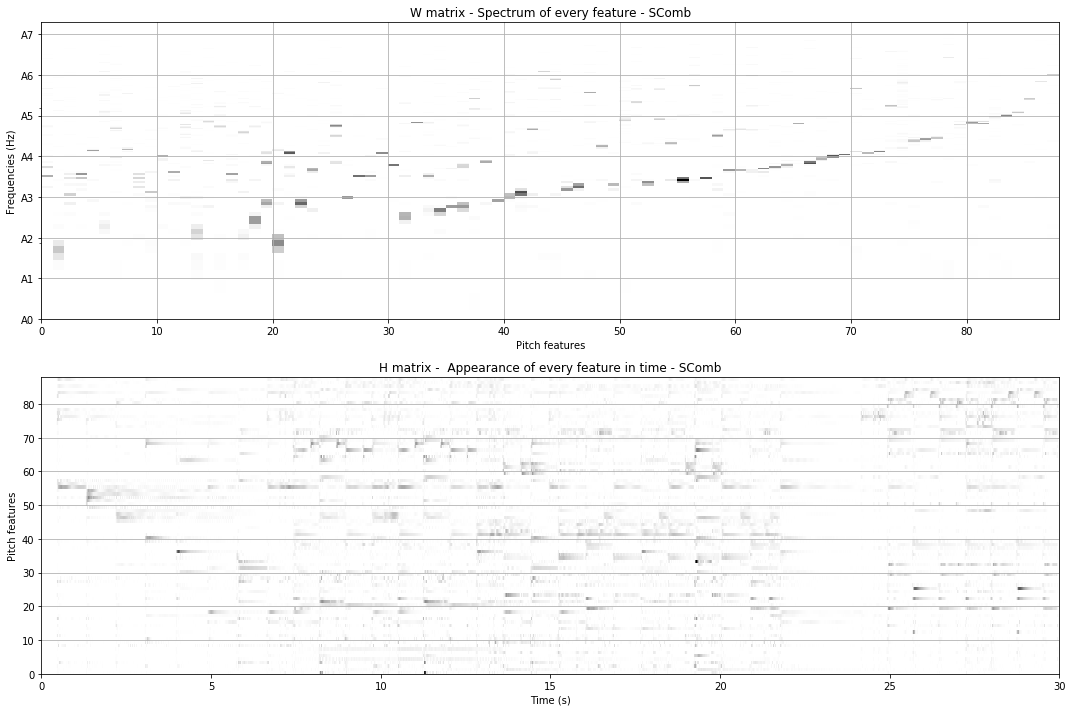

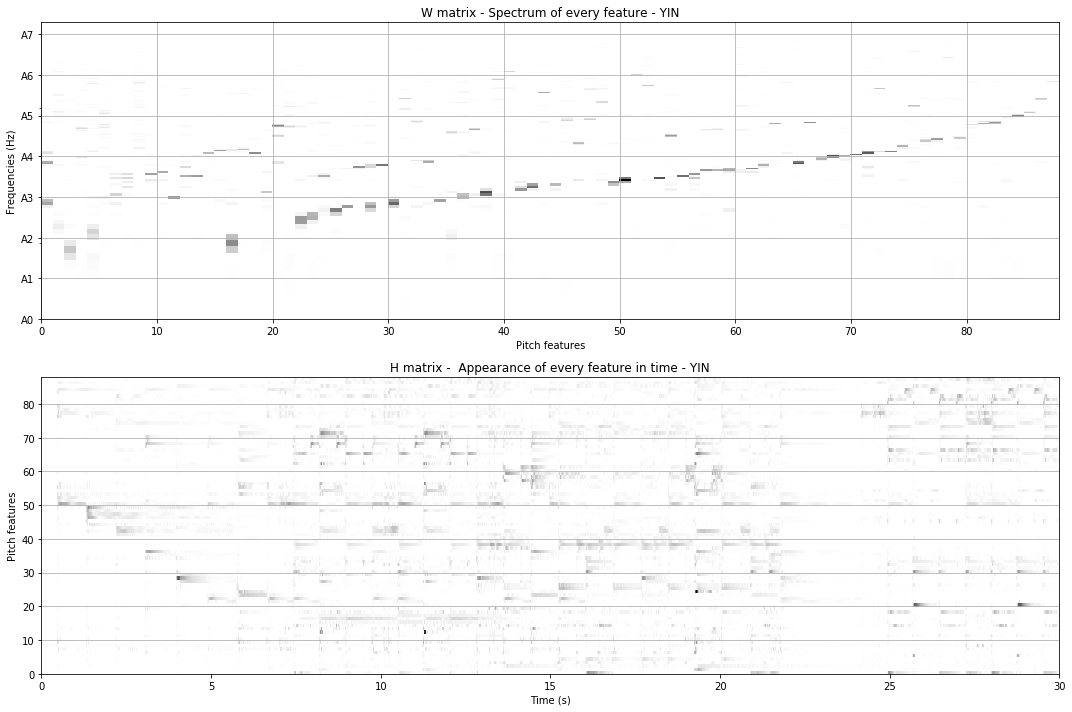

In [7]:
#Sort the colunms of W according to f0, arrange the rows of H accordingly
index=np.argsort(f0scomb)
Wsortscomb=W[:,index]
Hsortscomb=H[index,:]

index=np.argsort(f0yin)
Wsortyin=W[:,index]
Hsortyin=H[index,:]

# Maximun frequency to plot spectrum and spectrogram
plotWH(R, Wsortscomb, N, max_fr, min_fr, fs, frmTime, Hsortscomb, fig_dir, MIDI_FREQ, 'SComb')
plotWH(R, Wsortyin, N, max_fr, min_fr, fs, frmTime, Hsortyin, fig_dir, MIDI_FREQ, 'YIN')

Because we are using piano sounds, we constrain every pitch detected for every feature to the midi notes frequency, depending on the tunning frequency of A4.

Then we calculate the mean power of each note, and we use it to obtain a reference value for detecting onset and offsets of the notes.

This algorithm of note detection is described in this paper, section II-D:
Emmanuel Vincent, Nancy Bertin, Roland Badeau. Adaptive harmonic spectral decomposition for multiple pitch estimation. IEEE Trans. on Audio, Speech and Language Processing, IEEE, 2010, 18 (3), pp.528–537. <inria-00544094>

In [8]:
# Constrain the frequencies detected to the midi pitches according to the
# tunning frequency
print('Constraining to midi frequencies ...')
f0scomb = MIDI_constrain(good_features_scomb, f0scomb, MIDI_FREQ)
f0yin = MIDI_constrain(good_features_yin, f0yin, MIDI_FREQ)

Constraining to midi frequencies ...


For every frame of the H matrix, which contains the information of the occurrence of every feature per frame, we sum the total energy on a single note, if the energy is over the threshold, we consider that this note is played in that frame.

A preliminary piano roll is computed also, with dimension of 88 x number of frames.

Now, pitches occurrence with less than 80ms will be dropped from the piano roll

Here we obtain the "pitches per frame" representation of our estimated piano roll, this format is used by the mir_eval function.

Also is calculated, how many notes are simultaneously played.

In [9]:
# This is the function for estimate the pitches active per frames, it outputs the piano roll representation before and after filtering by 80ms lenght
# the pitches per frame to perform the evaluation and the filtered piano roll
piano_roll_scomb_prev, pitches_scomb, piano_roll_scomb, mpp_scomb = estimation(W, H, MIDI_FREQ, good_features_scomb, f0scomb, amp_thr, R, min_dur, fs, Hop, 'SComb')
piano_roll_yin_prev, pitches_yin, piano_roll_yin, mpp_yin = estimation(W, H, MIDI_FREQ, good_features_yin, f0yin, amp_thr, R, min_dur, fs, Hop, 'YIN')

------------------------------SComb----------------------------
Computing reference values for note on/off estimation ...
Maximum power of a pitch detected in 1 frame SComb: 0.2775430116988035
defining onsets and offsets of pitches ...
Computing preliminary estimated piano roll
filtering pitches with duration lower than 80ms ...
obtaining estimated pitches per frame ...
obtaining the piano roll matrix ...
simultaneous voices detected: 14
------------------------------YIN----------------------------
Computing reference values for note on/off estimation ...
Maximum power of a pitch detected in 1 frame YIN: 0.2858102752365269
defining onsets and offsets of pitches ...
Computing preliminary estimated piano roll
filtering pitches with duration lower than 80ms ...
obtaining estimated pitches per frame ...
obtaining the piano roll matrix ...
simultaneous voices detected: 14


Plotting the estimated piano roll representation by SComb and YIN

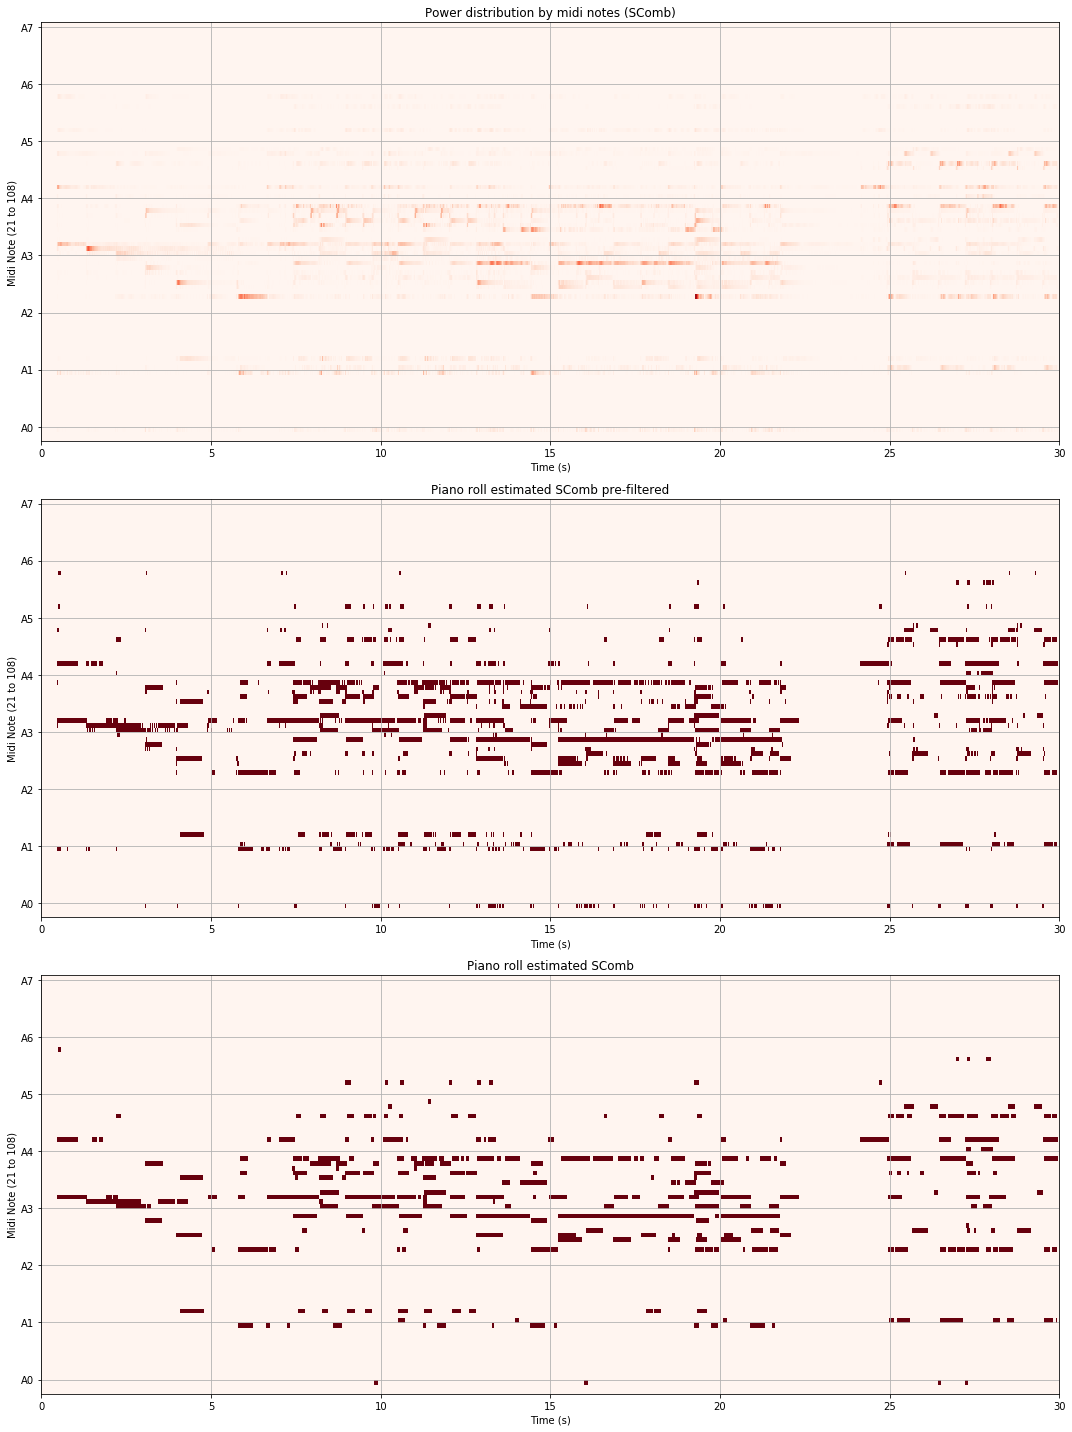

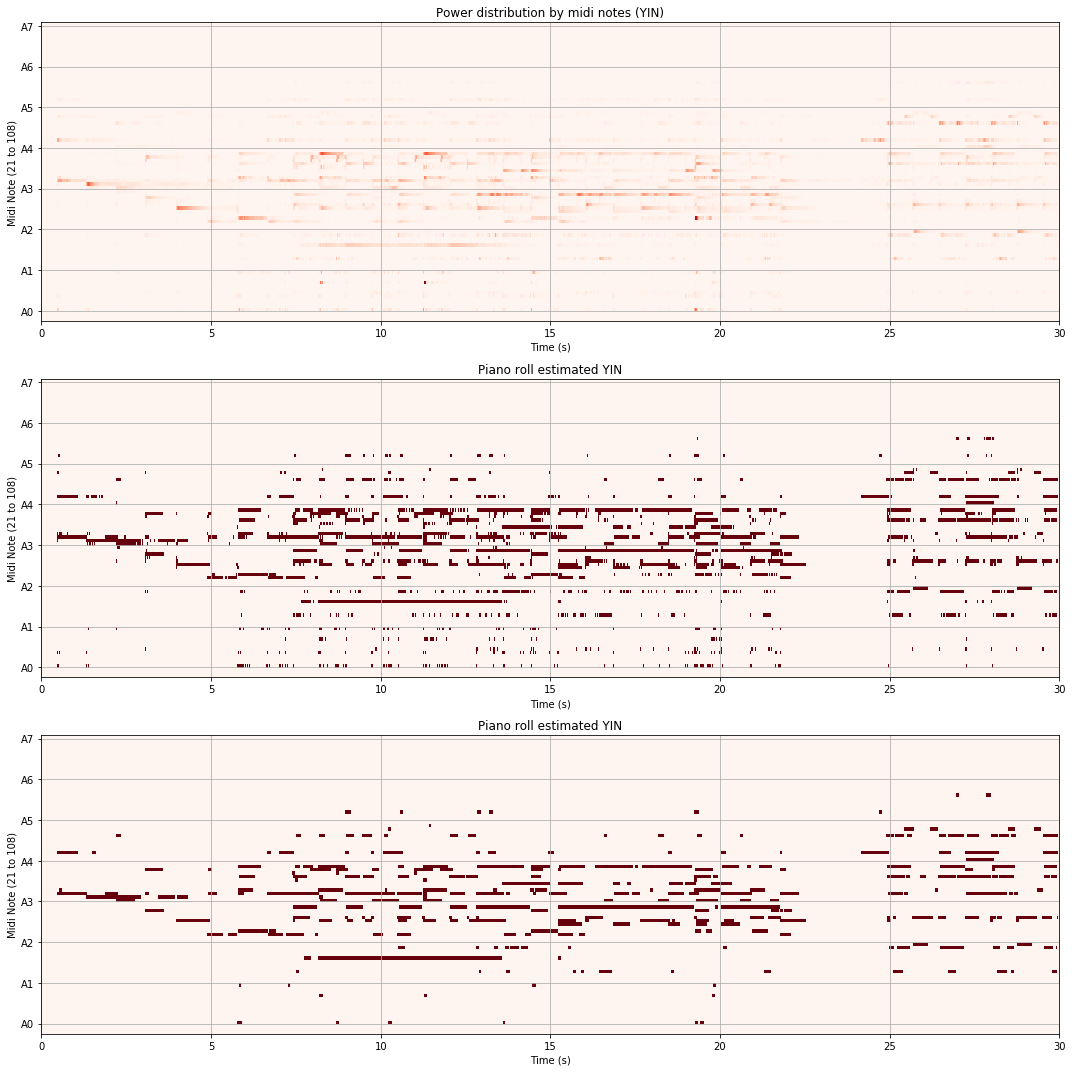

In [10]:
# Plot estimated piano roll SCOMB
cmap1 = plt.get_cmap('Reds')
plt.figure(figsize=(15, 20))
plt.subplot(311)
plt.pcolormesh(frmTime, np.arange(R+1), np.transpose(mpp_scomb), cmap = cmap1)
plt.yticks(np.arange(3,R+1,12), ['A0','A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7'])
plt.grid(True, which = 'both', axis = 'both')
plt.ylabel('Midi Note (21 to 108)')
plt.xlabel('Time (s)')
plt.title('Power distribution by midi notes (SComb)')
plt.autoscale(tight=True)
plt.tight_layout()
plt.subplot(312)
plt.pcolormesh(frmTime, np.arange(R+1), np.transpose(piano_roll_scomb_prev), cmap = cmap1)
plt.yticks(np.arange(3,R+1,12), ['A0','A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7'])
plt.grid(True, which = 'both', axis = 'both')
plt.ylabel('Midi Note (21 to 108)')
plt.xlabel('Time (s)')
plt.title('Piano roll estimated SComb pre-filtered')
plt.autoscale(tight=True)
plt.tight_layout()
plt.subplot(313)
plt.pcolormesh(frmTime, np.arange(R+1), np.transpose(piano_roll_scomb), cmap = cmap1)
plt.yticks(np.arange(3,R+1,12), ['A0','A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7'])
plt.grid(True, which = 'both', axis = 'both')
plt.ylabel('Midi Note (21 to 108)')
plt.xlabel('Time (s)')
plt.title('Piano roll estimated SComb')
plt.autoscale(tight=True)
plt.tight_layout()
plt.savefig(fig_dir + '/Estimated_Piano_Roll_Scomb.png')
plt.show()

# Plot estimated piano roll YIN
plt.figure(figsize=(15, 15))
plt.subplot(311)
plt.pcolormesh(frmTime, np.arange(R+1), np.transpose(mpp_yin), cmap = cmap1)
plt.yticks(np.arange(3,R+1,12), ['A0','A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7'])
plt.grid(True, which = 'both', axis = 'both')
plt.ylabel('Midi Note (21 to 108)')
plt.xlabel('Time (s)')
plt.title('Power distribution by midi notes (YIN)')
plt.autoscale(tight=True)
plt.tight_layout()
plt.subplot(312)
plt.pcolormesh(frmTime, np.arange(R+1), np.transpose(piano_roll_yin_prev), cmap = cmap1)
plt.yticks(np.arange(3,R+1,12), ['A0','A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7'])
plt.grid(True, which = 'both', axis = 'both')
plt.ylabel('Midi Note (21 to 108)')
plt.xlabel('Time (s)')
plt.title('Piano roll estimated YIN')
plt.autoscale(tight=True)
plt.tight_layout()
plt.subplot(313)
plt.pcolormesh(frmTime, np.arange(R+1), np.transpose(piano_roll_yin), cmap = cmap1)
plt.yticks(np.arange(3,R+1,12), ['A0','A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7'])
plt.grid(True, which = 'both', axis = 'both')
plt.ylabel('Midi Note (21 to 108)')
plt.xlabel('Time (s)')
plt.title('Piano roll estimated YIN')
plt.autoscale(tight=True)
plt.tight_layout()
plt.savefig(fig_dir + '/Estimated_Piano_Roll_YIN.png')
plt.show()

Obtaining the ground truth fron the text file provided in the database 

In [11]:
print('obtaining the piano roll from ground truth ...')
midi_piano_roll = np.zeros((len(frmTime), R))

with open(txt_file) as f:
    t_on = 0.;
    first_line = True
    while True:
        line = f.readline()
        if len(line) < 1:
            break
        if first_line:
            first_line = False
            continue
        t_on = float(line.split()[0])
        t_off = float(line.split()[1])
        midi_note = int(line.split()[2]) - 21
        fr_on = int(t_on*float(fs)/Hop)
        if fr_on >= len(midi_piano_roll) - 1:
            break
        fr_off = int(t_off*float(fs)/Hop)
        if fr_off > len(midi_piano_roll) - 1:
            fr_off = len(midi_piano_roll) - 1
        for t_pos in range(fr_on, fr_off+ 1):
            midi_piano_roll[t_pos][midi_note] = 1

obtaining the piano roll from ground truth ...


Plotting with the ground truth SComb and YIN estimation

plotting scomb piano roll with ground truth ...


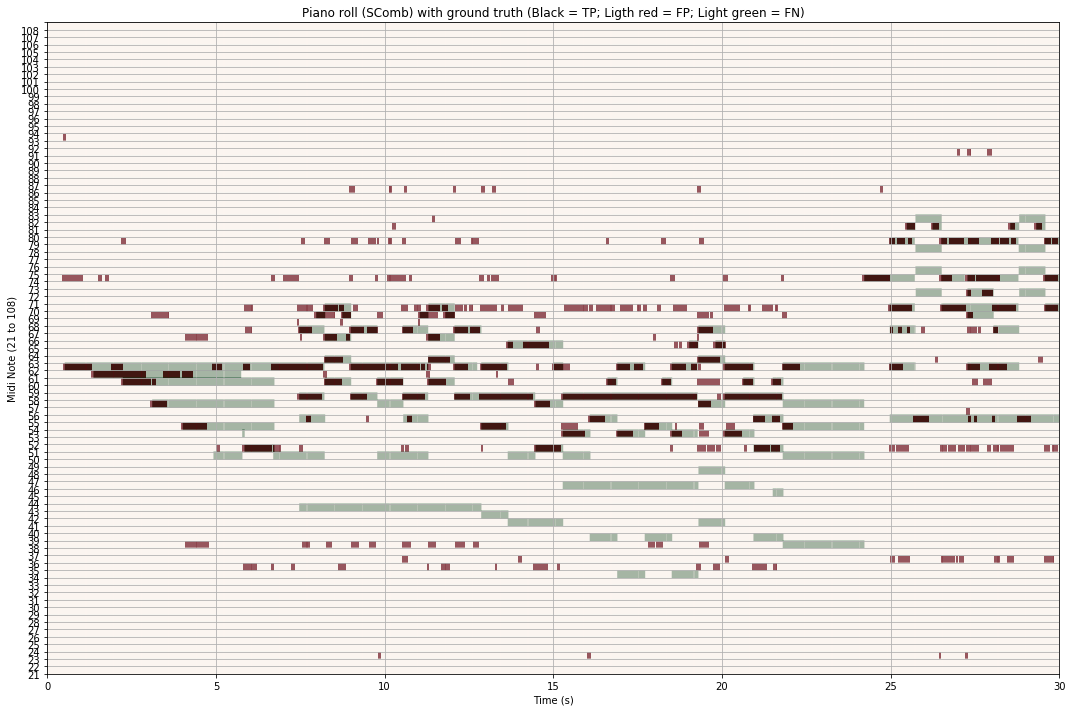

plotting yin piano roll with ground truth ...


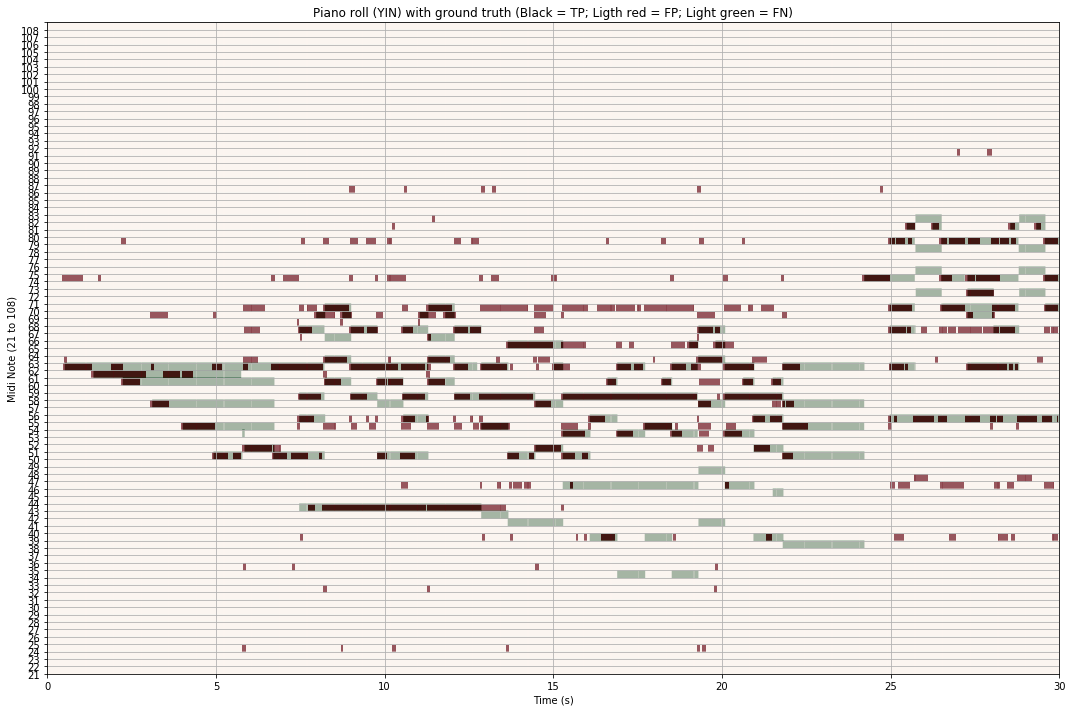

In [12]:
print('plotting scomb piano roll with ground truth ...')
cmap2 = plt.get_cmap('Greens')
plt.figure(figsize=(15, 10))
plt.pcolormesh(frmTime, np.arange(R+1), np.transpose(piano_roll_scomb), alpha = 1, cmap = cmap1)
plt.pcolormesh(frmTime, np.arange(R+1), np.transpose(midi_piano_roll), alpha = 0.1, cmap = cmap2)
plt.yticks(np.arange(R+1), np.arange(21,109))
plt.grid(True, which = 'both', axis = 'both')
plt.ylabel('Midi Note (21 to 108)')
plt.xlabel('Time (s)')
plt.title('Piano roll (SComb) with ground truth (Black = TP; Ligth red = FP; Light green = FN)')
plt.autoscale(tight=True)
plt.tight_layout()
plt.savefig(fig_dir + '/With_Ground_Truth_Piano_Roll_Scomb.png')
plt.show()

print('plotting yin piano roll with ground truth ...')
plt.figure(figsize=(15, 10))
plt.pcolormesh(frmTime, np.arange(R+1), np.transpose(piano_roll_yin), alpha = 1, cmap = cmap1)
plt.pcolormesh(frmTime, np.arange(R+1), np.transpose(midi_piano_roll), alpha = 0.1, cmap = cmap2)
plt.yticks(np.arange(R+1), np.arange(21,109))
plt.grid(True, which = 'both', axis = 'both')
plt.ylabel('Midi Note (21 to 108)')
plt.xlabel('Time (s)')
plt.title('Piano roll (YIN) with ground truth (Black = TP; Ligth red = FP; Light green = FN)')
plt.autoscale(tight=True)
plt.tight_layout()
plt.savefig(fig_dir + '/With_Ground_Truth_Piano_Roll_Yin.png')
plt.show()

Using the "pitches per frame" representation of the ground truth to analyse results with mir_eval

In [13]:
print('estimating precision values ...')
midi_pitches = []
for frame in midi_piano_roll:
    frame_list = []
    for m_note in range(len(frame)):
        if frame[m_note] == 1:
            frame_list.append(MIDI_FREQ[m_note])
    midi_pitches.append(np.array(frame_list))

estimating precision values ...


Obtaining the precision, recall and accuracy of our estimated piano rolls using mir_eval

In [14]:
# Evaluation by mir_eval
TP_scomb, FP_scomb, FN_scomb = evaluation(frmTime, pitches_scomb, midi_pitches, 'SComb')
TP_yin, FP_yin, FN_yin = evaluation(frmTime, pitches_yin, midi_pitches, 'YIN')

------------------------------SComb----------------------------
True Positives: 5546
False Positives: 3714
False Negatives: 7916
Precision: 59.89%
Recall: 41.20%
Accuracy: 32.29%
F-measure: 48.82%
------------------------------YIN----------------------------
True Positives: 7046
False Positives: 4085
False Negatives: 6416
Precision: 63.30%
Recall: 52.34%
Accuracy: 40.16%
F-measure: 57.30%


The formula to obtain this values are:

Precision = (TP/(TP + FP)); Recall = (TP/(TP + FN)); Accuracy = (TP/(TP + FP + FN))

With TP as true positives, FP as false positives and FN as false negatives.

Some of the results in many papers are given by the F-measure.